In [2]:
import pandas as pd
import io

In [5]:
from google.colab import drive
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Baca file langsung dari path Drive
# Ganti 'folder_project' dengan nama folder kamu di drive
path = '/content/online_retail_II.csv'
df = pd.read_csv(path)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# 1. Cleaning Ringan: Hanya ambil transaksi yang valid (Quantity > 0)
# Kita buang data retur/batal (biasanya negatif) agar perhitungan stok akurat
df_sales = df[df['Quantity'] > 0].copy()

# 2. Meringkas Data (Aggregation)
# Kita kelompokkan per barang untuk melihat total performanya
analisis_stok = df_sales.groupby(['StockCode', 'Description']).agg({
    'Quantity': 'sum',        # Total jumlah barang terjual
    'Invoice': 'nunique',     # Berapa kali barang ini muncul di struk (Frekuensi)
    'Price': 'mean'           # Rata-rata harga (sekedar info)
}).reset_index()

# 3. Rename kolom agar lebih mudah dibaca
analisis_stok.columns = ['KodeBarang', 'NamaBarang', 'TotalTerjual', 'FrekuensiTransaksi', 'Rata2Harga']

# 4. Mengurutkan dari yang PALING SEDIKIT terjual (Slow Moving)
# Barang-barang di urutan teratas adalah kandidat untuk DIKURANGI stoknya
stok_slow_moving = analisis_stok.sort_values(by='TotalTerjual', ascending=True)

# 5. Menampilkan 10 Barang Paling Tidak Laku
print("--- 10 BARANG DENGAN PENJUALAN TERENDAH (SLOW MOVING) ---")
display(stok_slow_moving.head(10))

# 6. (Opsional) Menampilkan Barang Paling Laris (Fast Moving) sebagai pembanding
print("\n--- SEBAGAI PEMBANDING: 10 BARANG PALING LARIS ---")
stok_fast_moving = analisis_stok.sort_values(by='TotalTerjual', ascending=False)
display(stok_fast_moving.head(10))

--- 10 BARANG DENGAN PENJUALAN TERENDAH (SLOW MOVING) ---


,KodeBarang,NamaBarang,TotalTerjual,FrekuensiTransaksi,Rata2Harga
3457,23628,SET 10 CARDS TRIANGLE ICONS 17220,1,1,2.91
5044,85024A,CRYSTAL SMALL JEWELLED PHOTOFRAME,1,1,1.65
5031,85017C,adjustment,1,1,0.00
5092,85043,RED HEART CANDY POP LIGHTS,1,1,4.95
3469,23643,SET 10 CARDS CHRISTMAS BAUBLE 16954,1,1,3.33
5068,85034b,3 WHITE CHOC MORRIS BOXED CANDLES,1,1,8.29
5134,85077,KISSING REINDEER TABLE RUNNER,1,1,5.95
5805,DCGS0075,CAMOUFLAGUE DOG LEAD,1,1,12.72
5010,84997d,PINK 3 PIECE MINI DOTS CUTLERY SET,1,1,7.62
5826,gift_0001_80,Dotcomgiftshop Gift Voucher £80.00,1,1,69.56



--- SEBAGAI PEMBANDING: 10 BARANG PALING LARIS ---


,KodeBarang,NamaBarang,TotalTerjual,FrekuensiTransaksi,Rata2Harga
4337,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,110249,1021,0.282919
5188,85123A,WHITE HANGING HEART T-LIGHT HOLDER,96091,5361,3.071457
4814,84879,ASSORTED COLOUR BIRD ORNAMENT,81817,2808,1.855104
3488,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,1,2.080000
5154,85099B,JUMBO BAG RED RETROSPOT,78866,3249,2.364513
2932,23166,MEDIUM CERAMIC TOP STORAGE JAR,78033,247,1.468480
126,17003,BROCADE RING PURSE,71440,457,0.302201
1443,21977,PACK OF 60 PINK PAISLEY CAKE CASES,56794,1993,0.711744
4982,84991,60 TEATIME FAIRY CAKE CASES,54716,2127,0.664032
1678,22197,SMALL POPCORN HOLDER,49984,1412,1.036660


In [7]:
# Pastikan ini dijalankan setelah df_clean / df_sales sudah dibuat

# --- TAHAP 1: BERSIHKAN "SAMPAH" (NOISE) ---
# Gunakan nama variabel dataframe kamu, misalnya df_sales
df_siap = df_sales.copy()

# === PERBAIKAN PENTING: Ubah kolom tanggal jadi datetime ===
# Error terjadi karena Python mencoba mengurangi string vs string.
# Kita harus ubah dulu jadi format tanggal.
df_siap['InvoiceDate'] = pd.to_datetime(df_siap['InvoiceDate'])

# Buang StockCode aneh (Test, Gift, Ongkir/Postage)
df_siap = df_siap[~df_siap['StockCode'].str.contains('TEST', na=False)]
df_siap = df_siap[~df_siap['StockCode'].str.contains('gift', case=False, na=False)]
df_siap = df_siap[~df_siap['StockCode'].str.contains('POST', na=False)]

# --- TAHAP 2: AGREGASI DENGAN WAKTU (RECENCY) ---
# Cek dulu nama kolom tanggal kamu. Biasanya 'InvoiceDate'.
# Kalau error lagi di 'InvoiceDate', ganti dengan nama kolom tanggal yg benar di data kamu.
tanggal_patokan = df_siap['InvoiceDate'].max()

analisis_stok_v2 = df_siap.groupby(['StockCode', 'Description']).agg({
    'Quantity': 'sum',          # Aman, nama kolom sama
    'Invoice': 'nunique',       # <--- SAYA UBAH DARI InvoiceNo KE Invoice
    'Price': 'mean',            # <--- SAYA UBAH DARI UnitPrice KE Price
    'InvoiceDate': 'max'        # Pastikan kolom ini ada
}).reset_index()

# Hitung 'Hari Tanpa Penjualan' (Days Inactive)
# Sekarang ini pasti berhasil karena tipe datanya sudah datetime
analisis_stok_v2['HariTerakhirLaku'] = (tanggal_patokan - analisis_stok_v2['InvoiceDate']).dt.days

# Rename kolom biar rapi
analisis_stok_v2.columns = ['KodeBarang', 'NamaBarang', 'TotalTerjual', 'Frekuensi', 'Rata2Harga', 'TglTerakhir', 'HariNganggur']

# --- TAHAP 3: CARI "TRUE" DEAD STOCK ---
# Syarat: Penjualan < 10 DAN sudah Nganggur > 90 hari
dead_stock = analisis_stok_v2[
    (analisis_stok_v2['TotalTerjual'] < 10) &
    (analisis_stok_v2['HariNganggur'] > 90)
].sort_values('HariNganggur', ascending=False)

print(f"Ditemukan {len(dead_stock)} barang Dead Stock.")
print("\n--- 10 BARANG YANG WAJIB DI-DISKON / CUCI GUDANG ---")
display(dead_stock[['NamaBarang', 'TotalTerjual', 'HariNganggur', 'Rata2Harga']].head(10))

Ditemukan 359 barang Dead Stock.

--- 10 BARANG YANG WAJIB DI-DISKON / CUCI GUDANG ---


,NamaBarang,TotalTerjual,HariNganggur,Rata2Harga
5255,BLACK BAROQUE CUCKOO CLOCK,1,737,26.04
1255,FRENCH STYLE WIRE DOOR CABINET,1,737,29.95
1170,MEDINA STAMPED METAL TRAY,3,737,14.95
1327,DADDY MOUSE RED GINGHAM BOW TIE,1,737,5.45
4183,TEATIME ROUND CAKE TINS,4,737,9.95
4187,ENGLISH ROSE SQUARE CAKE TINS,1,737,11.26
4601,NEW BAROQUE WALL MIRROR,1,737,12.75
4037,WHITE ADVENT CANDLE,1,737,4.30
3489,ASSORTED FRUIT STRAWS,1,737,1.70
317,*USB Office Glitter Lamp,1,737,8.65


In [8]:
# --- STEP TAMBAHAN: MEMBUAT product_data & SEGMENTASI ---

# 1. Ambil data dari tahap sebelumnya (analisis_stok_v2)
product_data = analisis_stok_v2.copy()

# 2. Hitung Total Revenue (TotalTerjual x Harga)
product_data['TotalRevenue'] = product_data['TotalTerjual'] * product_data['Rata2Harga']

# 3. Sesuaikan nama kolom agar cocok dengan kodemu (Description & Quantity)
product_data = product_data.rename(columns={
    'NamaBarang': 'Description',
    'TotalTerjual': 'Quantity'
})

# 4. Buat Kategori (High/Medium/Low Value)
# Kita pakai logika sederhana:
# - Top 20% Revenue tertingggi = High Value
# - Bottom 40% Revenue terendah = Low Value
# - Sisanya = Medium

batas_atas = product_data['TotalRevenue'].quantile(0.80) # 20% teratas
batas_bawah = product_data['TotalRevenue'].quantile(0.40) # 40% terbawah

def kategorikan(row):
    if row['TotalRevenue'] >= batas_atas:
        return 'High Value (Jagoan)'
    elif row['TotalRevenue'] <= batas_bawah:
        return 'Low Value (Beban/Mangkrak)'
    else:
        return 'Medium Value'

product_data['Kategori'] = product_data.apply(kategorikan, axis=1)

print("Berhasil membuat product_data!")
print(product_data['Kategori'].value_counts())

Berhasil membuat product_data!
Kategori
Low Value (Beban/Mangkrak)    2327
Medium Value                  2326
High Value (Jagoan)           1164
Name: count, dtype: int64


In [9]:
# --- FILTER BARANG CUCI GUDANG ---
# Kriteria:
# 1. Kategorinya 'Low Value' (Warna Abu-abu)
# 2. Sudah nganggur lebih dari 90 hari (Sebelah kanan garis merah)

barang_cuci_gudang = product_data[
    (product_data['Kategori'] == 'Low Value (Beban/Mangkrak)') &
    (product_data['HariNganggur'] > 90)
].sort_values('HariNganggur', ascending=False) # Urutkan dari yang paling lama berdebu

print(f"Ditemukan {len(barang_cuci_gudang)} barang yang harus Cuci Gudang!")
print("\n--- TOP 15 KANDIDAT UTAMA CLEARANCE SALE ---")
# Tampilkan kolom penting saja
cols = ['Description', 'HariNganggur', 'TotalRevenue', 'Quantity']
display(barang_cuci_gudang[cols].head(15))

# Tips Strategi:
# Barang-barang di list ini bisa kamu bundle: "Beli Barang Jagoan, Gratis Barang Ini"

Ditemukan 1364 barang yang harus Cuci Gudang!

--- TOP 15 KANDIDAT UTAMA CLEARANCE SALE ---


,Description,HariNganggur,TotalRevenue,Quantity
3501,SET OF 3 SILVER FLYING DUCKS,737,13.00,1
4469,DOTTY PLACEMATS,737,7.78,1
317,*USB Office Glitter Lamp,737,8.65,1
4183,TEATIME ROUND CAKE TINS,737,39.80,4
4187,ENGLISH ROSE SQUARE CAKE TINS,737,11.26,1
5255,BLACK BAROQUE CUCKOO CLOCK,737,26.04,1
1255,FRENCH STYLE WIRE DOOR CABINET,737,29.95,1
1170,MEDINA STAMPED METAL TRAY,737,44.85,3
1863,PARTY PIZZA DISH GREEN+WHITE SPOT,737,10.20,12
1327,DADDY MOUSE RED GINGHAM BOW TIE,737,5.45,1


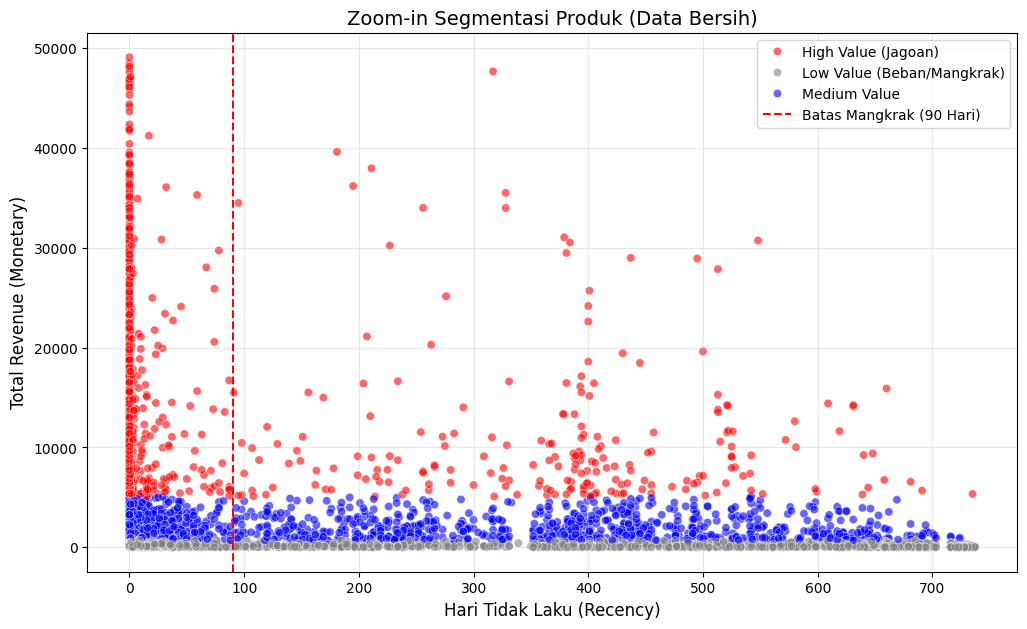

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- PERBAIKAN VISUALISASI ---
# Masalah: Ada barang 'Jagoan' (Outlier Atas) dan 'Aneh' (Outlier Bawah/Negatif) yang merusak skala grafik.
# Solusi: Kita filter grafik agar hanya menampilkan barang yang 'Wajar'.

# 1. Tentukan Batas Atas (Buang 1% barang termahal/revenue terbesar)
batas_atas = product_data['TotalRevenue'].quantile(0.99)

# 2. Filter Data
# - Revenue < Batas Atas (Buang Jagoan Ekstrem)
# - Revenue > 0 (Buang yang negatif/aneh di bawah)
df_plot = product_data[(product_data['TotalRevenue'] < batas_atas) & (product_data['TotalRevenue'] > 0)]

plt.figure(figsize=(12, 7))

# Plot data yang sudah difilter
sns.scatterplot(
    data=df_plot,
    x='HariNganggur',
    y='TotalRevenue',
    hue='Kategori',
    palette={
        'High Value (Jagoan)': 'red',
        'Medium Value': 'blue',
        'Low Value (Beban/Mangkrak)': 'grey'
    },
    alpha=0.6 # Transparansi biar kalau numpuk kelihatan
)

# Tambah garis batas (Threshold) visual
# Misal: Barang dianggap "Mangkrak" kalau > 90 hari
plt.axvline(x=90, color='red', linestyle='--', label='Batas Mangkrak (90 Hari)')

plt.title('Zoom-in Segmentasi Produk (Data Bersih)', fontsize=14)
plt.xlabel('Hari Tidak Laku (Recency)', fontsize=12)
plt.ylabel('Total Revenue (Monetary)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
from mlxtend.frequent_patterns import fpgrowth, association_rules # Ganti apriori dengan fpgrowth
import pandas as pd

# ==========================================
# 1. MEMBUAT KERANJANG BELANJA (OPTIMIZED)
# ==========================================

# [SOLUSI 1] Filter Data: Ambil UK saja (karena biasanya datanya paling banyak)
# Ini akan mengurangi beban RAM secara signifikan
df_basket = df_siap[df_siap['Country'] == 'United Kingdom']

print(f"Jumlah Transaksi setelah filter: {len(df_basket)}")

# Pivot Data
basket = (df_basket.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))

# [SOLUSI 2] Optimasi Memori:
# Daripada pakai applymap, pakai cara ini agar jadi boolean (True/False)
# Boolean jauh lebih hemat memori daripada int64
basket_sets = (basket > 0).astype(bool)

# Hapus kolom POSTAGE
if 'POSTAGE' in basket_sets.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)

print("Matriks siap. Mencari pola...")

# ==========================================
# 2. JALANKAN FP-GROWTH (LEBIH CEPAT DARI APRIORI)
# ==========================================
# [SOLUSI 3] FP-Growth lebih hemat memori dibanding Apriori
# min_support=0.02 (2%). Jika masih error, naikkan ke 0.03 atau 0.05
frequent_itemsets = fpgrowth(basket_sets, min_support=0.02, use_colnames=True)

# ==========================================
# 3. BUAT ATURAN (RULES)
# ==========================================
if not frequent_itemsets.empty:
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    # Sortir hasil
    top_rules = rules.sort_values(['lift', 'confidence'], ascending=False).head(10)

    print("\n--- REKOMENDASI BUNDLING TERBAIK ---")
    # Tampilkan kolom penting saja
    display(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("Tidak ditemukan pola. Coba turunkan min_support.")

Jumlah Transaksi setelah filter: 961025


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Matriks siap. Mencari pola...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- REKOMENDASI BUNDLING TERBAIK ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,support,confidence,lift
50,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.021233,0.630769,24.619460
51,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.021233,0.828723,24.619460
52,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.020006,0.780851,22.557988
53,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),0.020006,0.577953,22.557988
49,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.025512,0.737008,21.894803
48,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.025512,0.757895,21.894803
58,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.020197,0.648294,19.544172
59,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.020197,0.608874,19.544172
20,(VINTAGE SNAP CARDS),(VINTAGE HEADS AND TAILS CARD GAME ),0.020197,0.414661,12.720329
21,(VINTAGE HEADS AND TAILS CARD GAME ),(VINTAGE SNAP CARDS),0.020197,0.619565,12.720329


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

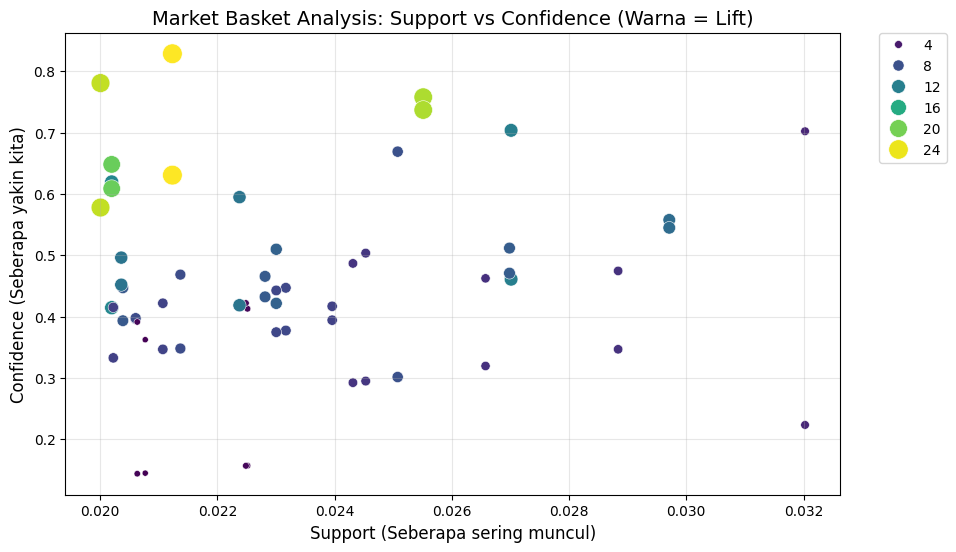

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3449523916.py:50: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, widt

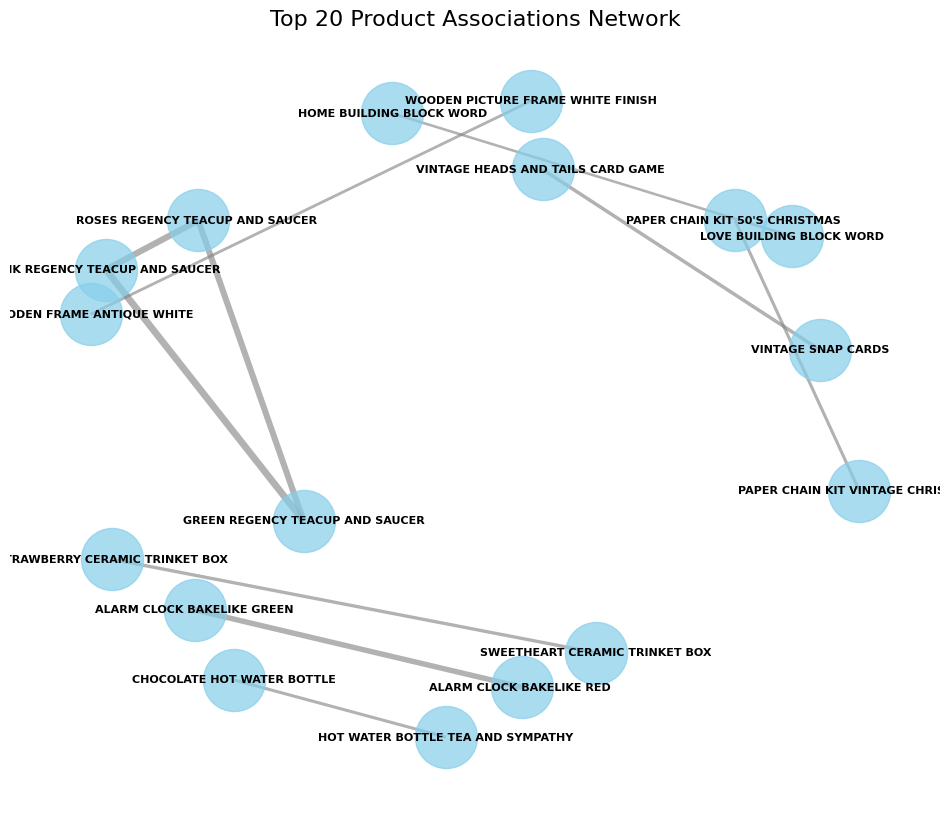

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

# ==========================================
# 1. SCATTER PLOT
# ==========================================
# Grafik ini memetakan semua aturan yang ditemukan.
# Warna semakin gelap/besar = Lift semakin tinggi (hubungan makin kuat)

plt.figure(figsize=(10, 6))
sns.scatterplot(x="support", y="confidence", size="lift", hue="lift",
                data=rules, palette="viridis", sizes=(20, 200))
plt.title('Market Basket Analysis: Support vs Confidence (Warna = Lift)', fontsize=14)
plt.xlabel('Support (Seberapa sering muncul)', fontsize=12)
plt.ylabel('Confidence (Seberapa yakin kita)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 2. NETWORK GRAPH (Visualisasi Jaringan)
# ==========================================
# Ini yang paling keren. Kita bisa lihat produk mana yang jadi "pusat".
# Kita ambil Top 20 rules saja biar grafiknya tidak ruwet seperti benang kusut.

# Persiapan Data: Ubah frozenset jadi string biasa
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents_str'] = rules['consequents'].apply(lambda x: list(x)[0])

# Filter top rules berdasarkan Lift
top_rules_graph = rules.sort_values('lift', ascending=False).head(20)

# Buat Graph
G = nx.from_pandas_edgelist(top_rules_graph,
                            source='antecedents_str',
                            target='consequents_str',
                            edge_attr='lift')

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=1.5) # k mengatur jarak antar node

# Gambar Node (Titik Produk)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.7)

# Gambar Edge (Garis Hubungan)
# Ketebalan garis berdasarkan nilai Lift (makin kuat makin tebal)
weights = [G[u][v]['lift'] / 5 for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='grey', alpha=0.6, arrowstyle='->', arrowsize=20)

# Gambar Label (Nama Produk)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif', font_weight='bold')

plt.title('Top 20 Product Associations Network', fontsize=16)
plt.axis('off')
plt.show()